# A proposal for
## Trully Runnable Obvious Lame-Learning In Issued Guessing
### A rocket.ai division

# Working with sentiment

In [1]:
%matplotlib inline

import json
import zlib


import seaborn as sns

import config

# Import
with open(config.DATASET_MUCHOCINE, 'r') as fd:
    documents = json.loads(zlib.decompress(fd.read()))

## Split train-test

In [2]:
from collections import Counter

from sklearn.model_selection import train_test_split
import numpy as np

SEED = 1
train, test = train_test_split(documents, train_size=0.7, random_state=SEED)

#TRAIN
train_X = [Counter(doc['body_tokens']) for doc in train]
train_Y = [float(x['rank']) for x in train]

#TEST
test_X = [Counter(doc['body_tokens']) for doc in test]
test_Y = [float(x['rank']) for x in test]

## Train model

### TF-IDF

In [3]:
from sklearn.feature_extraction import DictVectorizer

model_vectorizer = DictVectorizer()
tr_data = model_vectorizer.fit_transform(train_X)

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

model_tfidf = TfidfTransformer()
tr_data = model_tfidf.fit_transform(tr_data).todense()

In [5]:
tr_data.shape

(2714, 39127)

#### Quick think

39127 parameters to fit with only 2714 samples is a bad deal.

It will be nice to reduce the terms to the n-most frequent.

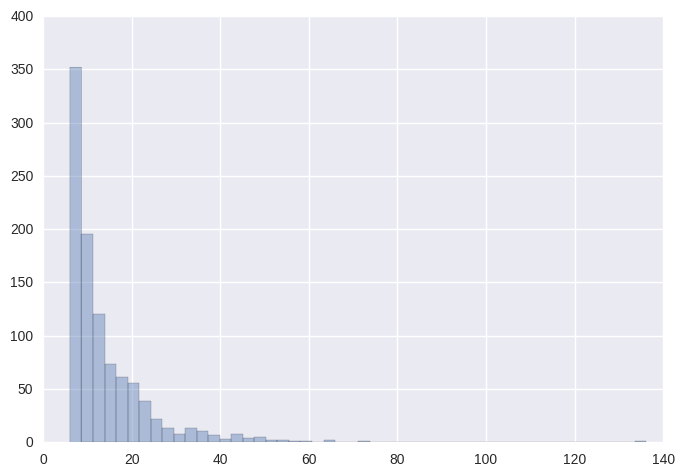

In [6]:
N = 1000

terms_weight = sorted(zip(tr_data.sum(axis=0).tolist()[0], model_vectorizer.get_feature_names()), reverse=True)[:N]
sns.distplot([x[0] for x in terms_weight], kde=False)

### Feature model

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

N = 200  # Features to select

model_feature = SelectKBest(f_regression, k=N)
tr_data = model_feature.fit_transform(tr_data, train_Y)

In [8]:
tr_data.shape

(2714, 200)

### Standardize weights

In [9]:
from sklearn.preprocessing import StandardScaler

model_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
tr_data = model_scaler.fit_transform(tr_data)

### Linear regression

In [10]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression(n_jobs=1)
tr_data = model_scaler.transform(tr_data)
model_LR.fit(tr_data, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### MSE

In [11]:
from sklearn.metrics import mean_squared_error

def predict(data):
    return (
        model_LR.predict(
            model_scaler.transform(
                model_feature.transform(
                    model_tfidf.transform(
                        model_vectorizer.transform(data)
                    ).todense()
                )
            )
        )
    )

In [12]:
mean_squared_error(train_Y, predict(train_X))

1.2712053502386853

In [13]:
mean_squared_error(test_Y, predict(test_X))

1.3150696043156578

In [14]:
model_LR.coef_.shape

(200,)

## Selected vars

In [15]:
terms_selected = [
    term
    for term, appears in
    zip(model_vectorizer.get_feature_names(),model_feature.get_support())
    if appears
]

In [16]:
sorted(zip(terms_selected, model_LR.coef_),  key=lambda (_,x):x, reverse=True)

[(u'mejor', 0.001713783735862966),
 (u'film', 0.0014485294873798249),
 (u'mund', 0.0013470345196592566),
 (u'espartan', 0.0013309413117559398),
 (u'excelent', 0.0012870223690622073),
 (u'genial', 0.0012496171099285478),
 (u'perfect', 0.001243687410658571),
 (u'maravill', 0.0012033987114460707),
 (u'vid', 0.0010890352700525421),
 (u'violenci', 0.00091114409554354987),
 (u'imprescind', 0.00088508915922226312),
 (u'impresion', 0.00079433880683922511),
 (u'obra', 0.00078492508515546125),
 (u'sent', 0.00072518089887132489),
 (u'peliculon', 0.0006983781667679633),
 (u'dav', 0.00061842972321153925),
 (u'magistral', 0.00061257329422897402),
 (u'propi', 0.00060738743780185079),
 (u'sobresalient', 0.00059949115248513363),
 (u'brillant', 0.00058647359032831413),
 (u'vari', 0.00056986041668460072),
 (u'cad', 0.00056649094187987195),
 (u'dentr', 0.00055967279575836078),
 (u'magnif', 0.00055578774306511603),
 (u'9', 0.00048970183843736613),
 (u'plac', 0.00048429243430214757),
 (u'impact', 0.00046699

# Human test

In [17]:
# Función de pasar textos a tokens, del cuaderno anterior

STOPWORDS = set('''
a al algo algunas algunos ante antes como con contra cual cuando de del desde donde durante e el ella ellas ellos
en entre era erais eran eras eres es esa esas ese eso esos esta estaba estabais estaban estabas estad estada estadas
estado estados estamos estando estar estaremos estara estaran estaras estare estareis estaria estariais estariamos
estarian estarias estas este estemos esto estos estoy estuve estuviera estuvierais estuvieran estuvieras estuvieron
estuviese estuvieseis estuviesen estuvieses estuvimos estuviste estuvisteis estuvieramos estuviesemos estuvo esta
estabamos estais estan estas este esteis esten estes fue fuera fuerais fueran fueras fueron fuese fueseis fuesen fueses
fui fuimos fuiste fuisteis fueramos fuesemos ha habida habidas habido habidos habiendo habremos habra habran habras
habre habreis habria habriais habriamos habrian habrias habeis habia habiais habiamos habian habias han has hasta
hay haya hayamos hayan hayas hayais he hemos hube hubiera hubierais hubieran hubieras hubieron hubiese hubieseis
hubiesen hubieses hubimos hubiste hubisteis hubieramos hubiesemos hubo la las le les lo los me mi mis mucho muchos
muy mas mi mia mias mio mios nada ni no nos nosotras nosotros nuestra nuestras nuestro nuestros o os otra otras otro
otros para pero poco por porque que quien quienes que se sea seamos sean seas sentid sentida sentidas sentido sentidos
seremos sera seran seras sere sereis seria seriais seriamos serian serias seais siente sin sintiendo sobre sois somos
son soy su sus suya suyas suyo suyos si tambien tanto te tendremos tendra tendran tendras tendre tendreis tendria
tendriais tendriamos tendrian tendrias tened tenemos tenga tengamos tengan tengas tengo tengais tenida tenidas tenido
tenidos teniendo teneis tenia teniais teniamos tenian tenias ti tiene tienen tienes todo todos tu tus tuve tuviera
tuvierais tuvieran tuvieras tuvieron tuviese tuvieseis tuviesen tuvieses tuvimos tuviste tuvisteis tuvieramos tuviesemos
tuvo tuya tuyas tuyo tuyos tu un una uno unos vosostras vosostros vuestra vuestras vuestro vuestros y ya yo el eramos
'''.split())

from nltk.stem.snowball import SpanishStemmer
stemmer = SpanishStemmer()

def txt2words(txt):
    txt = txt.lower()  # Text in lowercase
    table = dict(zip( #  Quitar tildes
        [ord(x) for x in u'áéíóúü'],
        [ord(x) for x in u'aeiouu']
    ))
    txt = txt.translate(table)    
    txt = ''.join([
        letter for letter in txt 
        if letter in set(u'abcdefghijklmnñopqrstuvwxyz0123456789 ')]
    )
    words = [
        stemmer.stem(w)
        for w in txt.split(' ')
        if w!='' and w not in STOPWORDS
    ]
    return words

In [18]:
def sentiment(txt):
    return predict(Counter(txt2words(txt)))

In [19]:
sentiment(u"La película me pareció una obra maestra y genial.")

array([ 3.12112853])

In [20]:
sentiment(u"La película es aburrida, mala, una mierda")

array([ 2.99744358])

# Conclusion

2 different problems.

* Good ranking words.
* Bad modelling prediction.

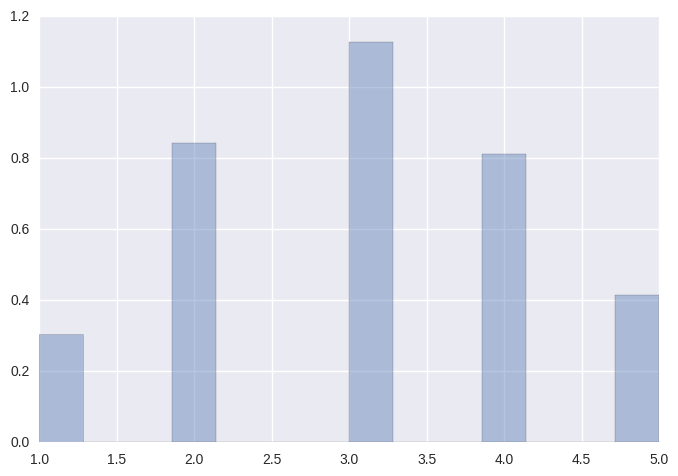

In [21]:
sns.distplot(train_Y, kde=False, norm_hist=True )

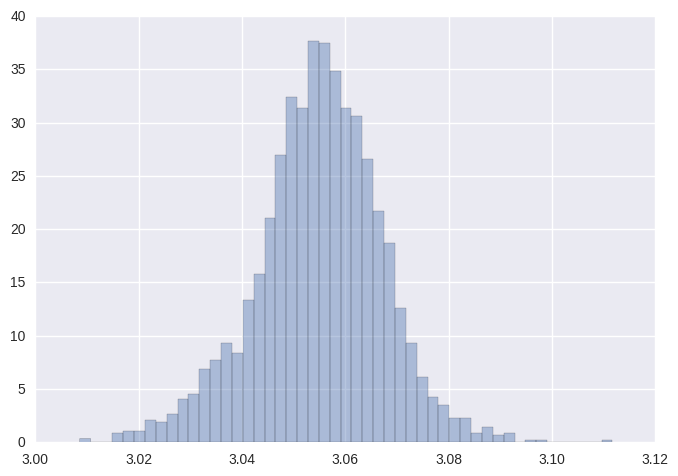

In [22]:
sns.distplot(predict(train_X), kde=False, norm_hist=True )

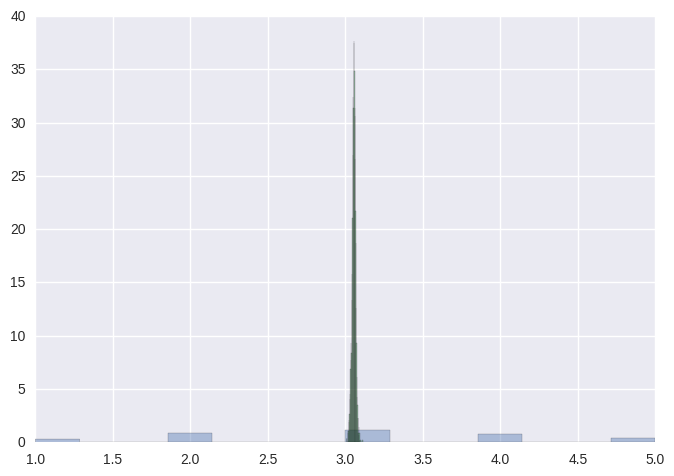

In [23]:
sns.distplot(train_Y, kde=False, norm_hist=True )
sns.distplot(predict(train_X), kde=False, norm_hist=True )

# The last punch!

In [24]:
q = predict(train_X)

def sentiment2(txt):
    pred = predict(Counter(txt2words(txt)))
    return (pred-q.mean())/(q.max()-q.min())*(1-(-1))

In [25]:
sentiment2(u"La película me pareció una obra maestra y genial.")

array([ 1.28458163])

In [26]:
sentiment2(u"La película es aburrida, mala, una mierda")

array([-1.11480351])

In [27]:
sentiment2(u"volveré a verla ya que la actuacion buena")

array([ 0.01410884])

In [29]:
sentiment2(u"los oscars se los regalaron, vaya pérdida de tiempo")

array([-0.07699173])

In [30]:
sentiment2(u"el actor es un capullo pero le gustó a mi novia porque ejerce la violencia inteligentemente")

array([ 0.28917081])